In [10]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb

# Wczytanie danych

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv(url, delim_whitespace=True, names=names)

/tmp/ipykernel_6362/3994773014.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset = pd.read_csv(url, delim_whitespace=True, names=names)


# EDA

In [21]:
df = dataset
print("Podstawowe informacje o zbiorze:")
display(df.info())

print("\nStatystyki opisowe:")
print(df.describe())

print("\nLiczba brakujących wartości w każdej kolumnie:")
display(df.isnull().sum())


Podstawowe informacje o zbiorze:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


None


Statystyki opisowe:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std   

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Rozkład cech w zbiorze

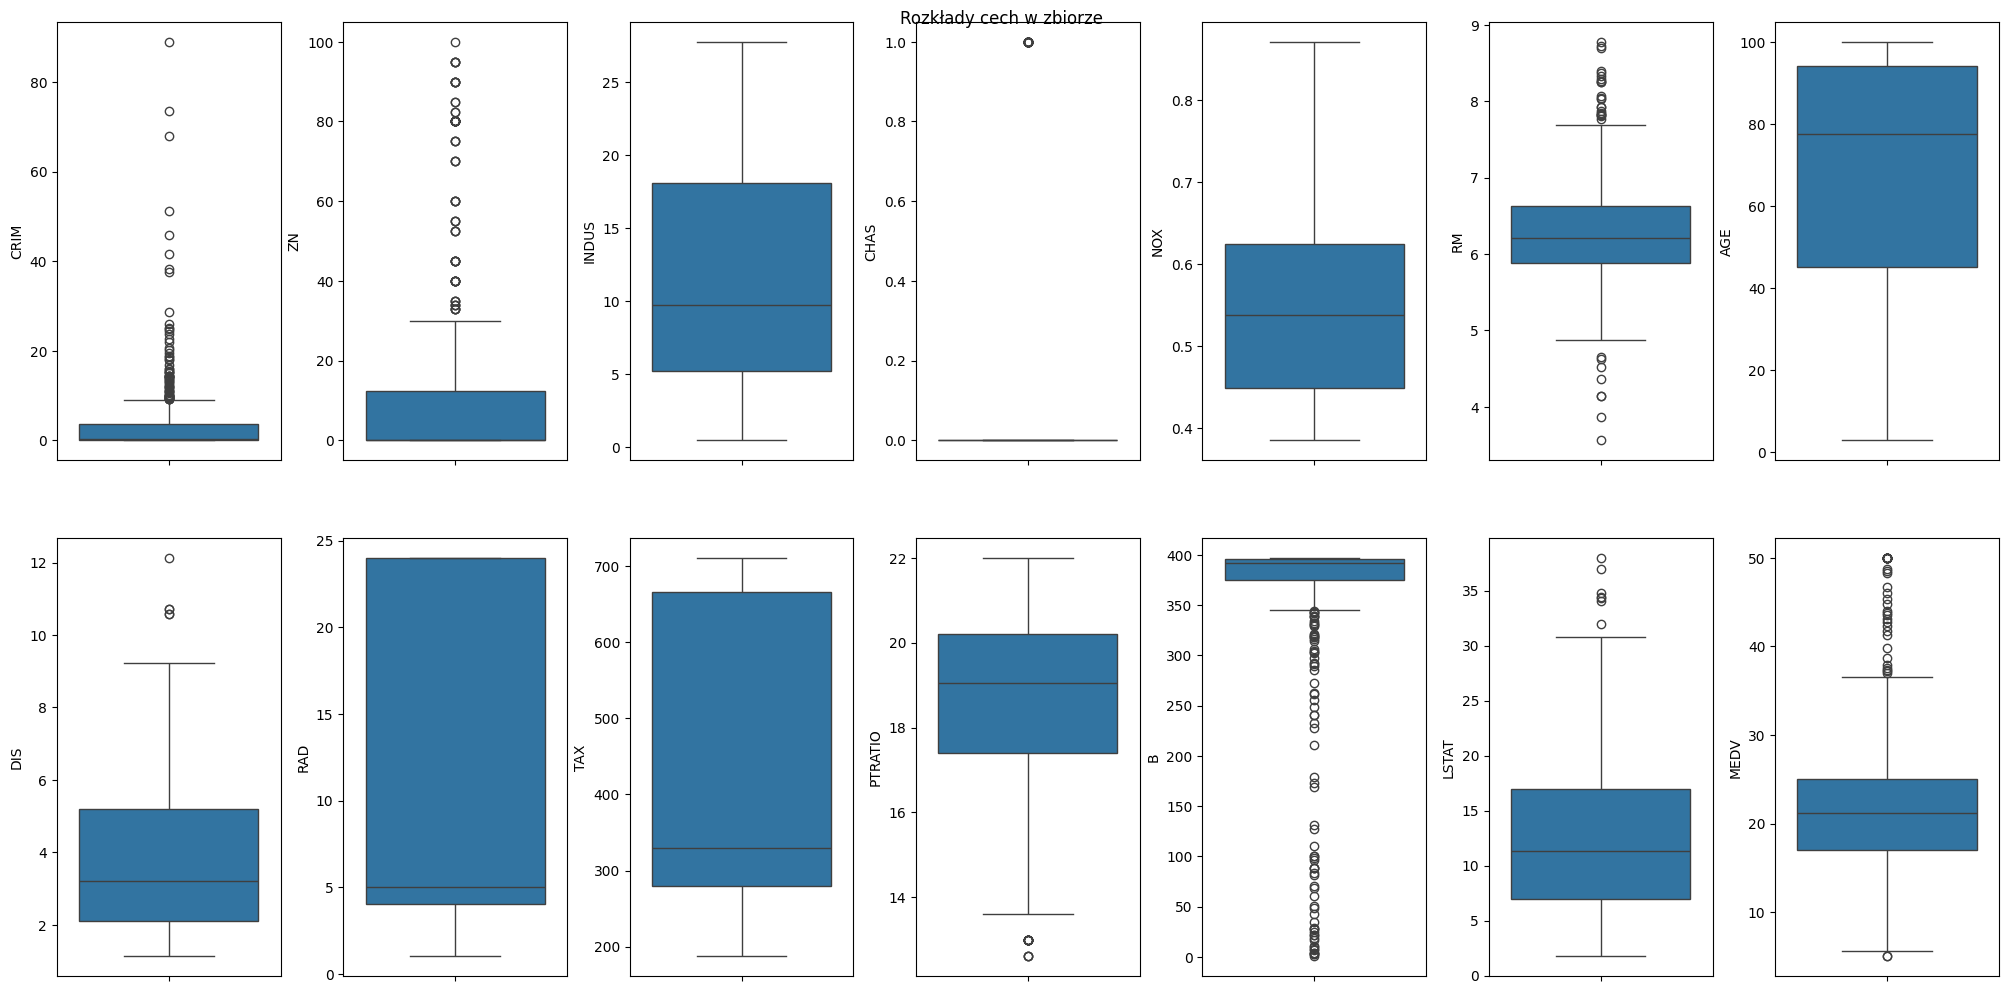

In [18]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i,j in df.items():
    sns.boxplot(y=i, data=df, ax=axs[index])
    index += 1
plt.suptitle('Rozkłady cech w zbiorze ')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


### Rozkład MEDV

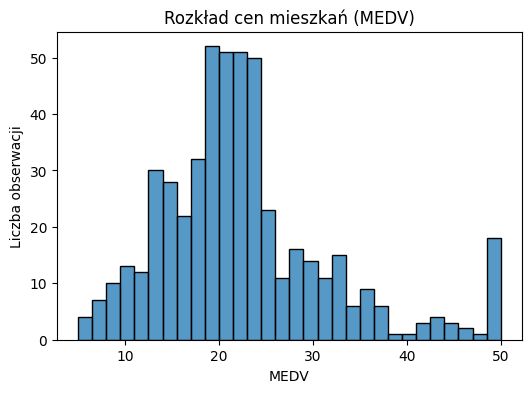

In [ ]:

plt.figure(figsize=(6, 4))
sns.histplot(df['MEDV'], bins=30)
plt.title('Rozkład cen mieszkań (MEDV)')
plt.xlabel('MEDV')
plt.ylabel('Liczba obserwacji')
plt.show()


## Sprawdzenie współliniowości

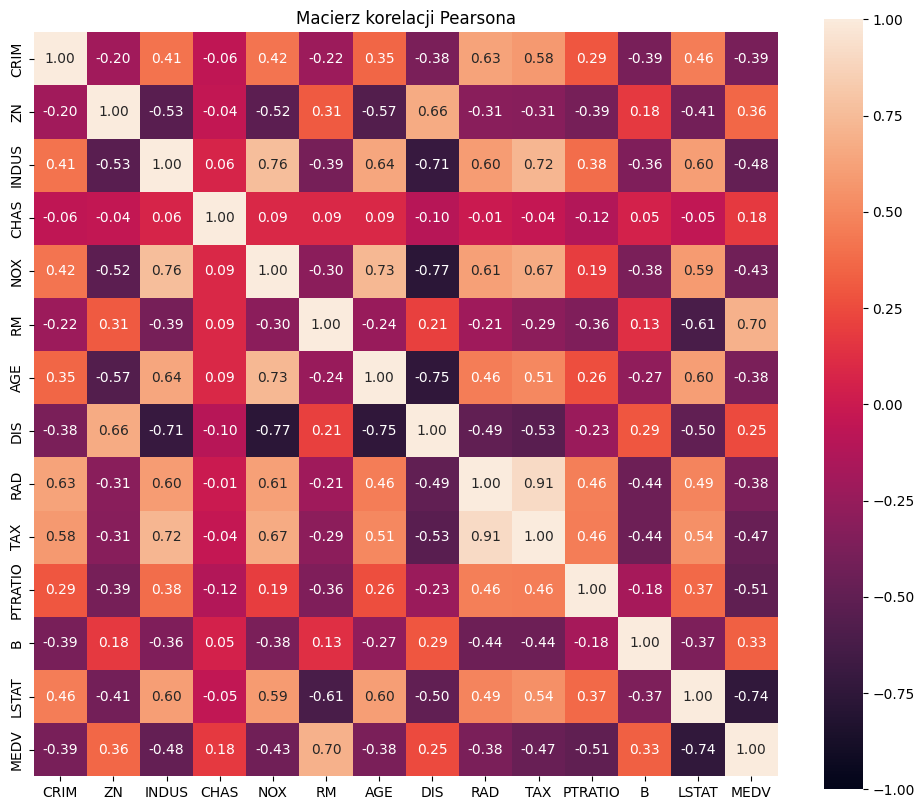

In [13]:

plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', square=True, vmin=-1, vmax=1)
plt.title('Macierz korelacji Pearsona')
plt.show()


In [14]:

print("\nPary zmiennych o wysokiej korelacji (|r| > 0.75):")
high_corr = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[high_corr < 1]
display(high_corr[high_corr > 0.75])



Pary zmiennych o wysokiej korelacji (|r| > 0.75):


RAD    TAX      0.910228
TAX    RAD      0.910228
DIS    NOX      0.769230
NOX    DIS      0.769230
INDUS  NOX      0.763651
NOX    INDUS    0.763651
dtype: float64

In [19]:

# Opcjonalnie: Współczynnik VIF (Variance Inflation Factor) do analizy współliniowości
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df.drop('MEDV', axis=1)
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nWspółczynniki VIF:")
print(vif_data.sort_values(by='VIF', ascending=False))



Współczynniki VIF:
    feature        VIF
10  PTRATIO  85.029547
5        RM  77.948283
4       NOX  73.894947
9       TAX  61.227274
6       AGE  21.386850
11        B  20.104943
8       RAD  15.167725
7       DIS  14.699652
2     INDUS  14.485758
12    LSTAT  11.102025
1        ZN   2.844013
0      CRIM   2.100373
3      CHAS   1.152952


# Podział na zbiór treningowy i testowy

In [23]:
# Podział zbioru danych
X = dataset.drop('MEDV', axis=1)
y = dataset['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Badanie modeli

In [24]:
# Regresja Liniowa
lr = LinearRegression()
lr.fit(X_train, y_train)

# XGBoost
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                        max_depth=5, alpha=10, n_estimators=10)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=None, ...)

# GridSearchCV dla XGBoost

In [26]:
# GridSearchCV dla XGBoost
params = {'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200]}
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)
grid = GridSearchCV(estimator=xg_reg, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print("Best score: %.2f using params: %s" % (grid.best_score_, grid.best_params_))

Best score: -13.74 using params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


# Test vs Train

In [25]:
# Ewaluacja modeli

# Regresja liniowa
y_pred_lr = lr.predict(X_test)
print('Linear Regression - MSE: ', mean_squared_error(y_test, y_pred_lr))
print('Linear Regression - MAE: ', mean_absolute_error(y_test, y_pred_lr))
print('Linear Regression - R2: ', r2_score(y_test, y_pred_lr))

# XGBoost
y_pred_xg = xg_reg.predict(X_test)
print('XGBoost - MSE: ', mean_squared_error(y_test, y_pred_xg))
print('XGBoost - MAE: ', mean_absolute_error(y_test, y_pred_xg))
print('XGBoost - R2: ', r2_score(y_test, y_pred_xg))

Linear Regression - MSE:  24.291119474973478
Linear Regression - MAE:  3.189091965887837
Linear Regression - R2:  0.6687594935356326
XGBoost - MSE:  40.061291602494165
XGBoost - MAE:  4.234852414972642
XGBoost - R2:  0.4537130108927857


# Założenia Regresji Liniowej

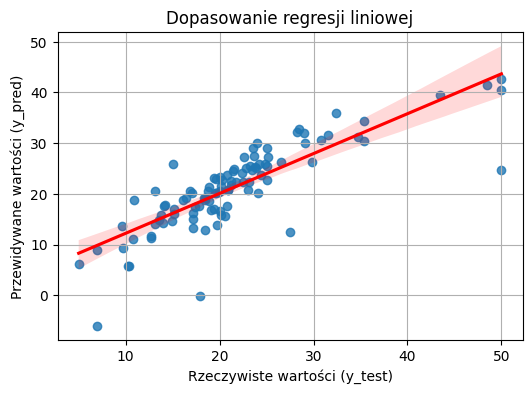

In [43]:
plt.figure(figsize=(6, 4))
sns.regplot(x=y_test, y=y_pred_lr, line_kws={"color": "red"})
plt.xlabel("Rzeczywiste wartości (y_test)")
plt.ylabel("Przewidywane wartości (y_pred)")
plt.title("Dopasowanie regresji liniowej")
plt.grid()
plt.show()

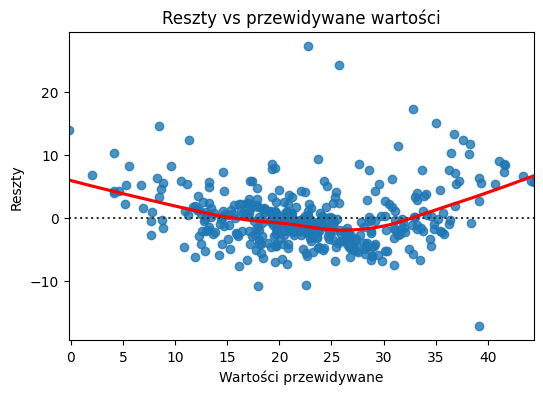

In [42]:
y_train_pred = lr.predict(X_train)
residuals = y_train - y_train_pred

plt.figure(figsize=(6, 4))
sns.residplot(x=y_train_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Reszty vs przewidywane wartości')
plt.show()


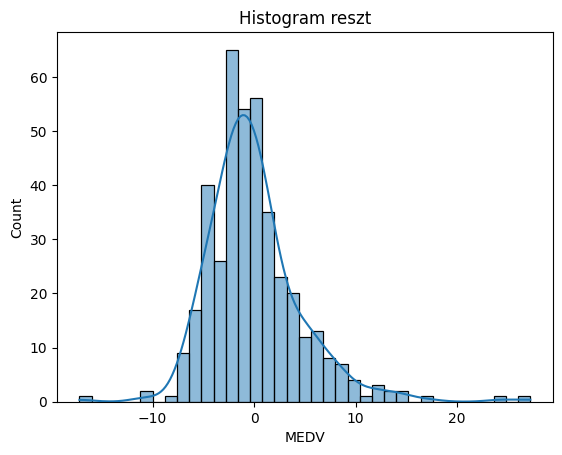

In [ ]:

sns.histplot(residuals, kde=True)
plt.title("Histogram reszt")
plt.show()

## Regresja liniowa nie spełnia założeń, ponieważ:

- Na wykresie widać, że residua mają różne rozproszenie (przy skrajnych wartościach są bardziej rozrzucone).  To znaczy, że ich rozrzut nie jest taki sam w całym zakresie, a w regresji liniowej powinien być stały.
- Histogram reszt jest lekko przekrzywiony (prawoskośny), więc nie przypomina rozkładu normalnego, jak powinien.